In [1]:
import os, sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.distributions import Categorical

import gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/実験コード/RL_algorithms/A2C/')
from agent import  Agent
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/実験コード/RL_algorithms/Memory/')
from PrioritizedExperienceMemory import ProportionalReplayMemory
from Memory import Replay_Memory
from PrioritizedExperienceMemoryNsplit import ProportionalReplayNsplitMemory

In [3]:
class Environment:
    def get_state(self, env, _obs):
        env_low = env.observation_space.low 
        env_high = env.observation_space.high 
        # normalize
        state = (_obs - env_low)/(env_high - env_low)
        return state.tolist()

    def get_reward(self, env, _obs, reward):
        reward = float(_obs[0])
        #reward = float(reward)
        #env_low = env.observation_space.low 
        #env_high = env.observation_space.high 
        # normalize
        #state = (_obs - env_low)/(env_high - env_low)
        return reward
    def get_action(self,env, action):
        action = int(action)

        return action

    def get_data(self, env, obs, next_obs, reward, action):
        state = self.get_state(env, obs)
        next_state = self.get_state(env, next_obs)
        
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        reward = float((next_obs[0]-low)/(high-low))
        if reward<0.5:
            reward = 0
        if reward>0.85:
            reward*=2
        #reward = self.get_reward(env, reward)
        action = self.get_action(env, action)

        return state, action, next_state, reward

In [4]:
#make env
env = gym.make('MountainCar-v0')

In [19]:
action_space = env.action_space.n
environment = Environment()
#replay_memory = Replay_Memory(100000)
replay_memory = ProportionalReplayNsplitMemory(10000,n=15)
agent = Agent(action_space=action_space, nSplit=True)

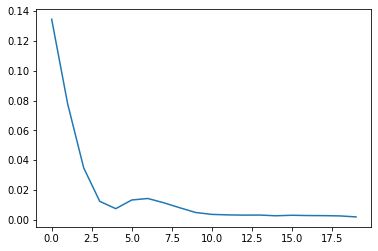

In [20]:
# 楽観的初期化
loss_list = agent.init_param_optim(20, env, environment)
plt.plot(loss_list)

In [21]:
actions = []
rewards = []
loss = []

In [22]:
# 10000エピソードで学習する
for episode in range(10):
    total_reward = 0
    observation = env.reset()
    for _ in range(5000):
        env.render()
        
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor([now_state])
        action =  agent.get_action(now_state)
        actions.append(action)
        
        #環境を取得
        next_observation, reward, done, _ = env.step(action)
        
        
        #optim parameters
        state, action, next_state, reward = environment.get_data(env, observation, next_observation, reward, action)
        replay_memory.push(state, action, next_state, reward)
        _loss = agent.update_agent(replay_memory)
        total_reward += reward
        
        if _loss is not None:
            loss.append(_loss)
        observation = next_observation
        if observation[0]>=env.observation_space.high[0]-0.001:
            # doneがTrueになったら１エピソード終了
            if episode%100 == 0:
                if episode==0:
                    mean_total_reward = total_reward
                else:
                    m = episode//100
                    mean_total_reward = np.mean(rewards[(m-1)*100:m*100])
                print(f'episode: {episode}, total_reward　mean: {mean_total_reward}')
            break
    rewards.append(total_reward)

KeyboardInterrupt: 

In [23]:
env.close()

In [24]:
#agent.policy_net.state_dict()

In [25]:
loss_df = pd.DataFrame(loss, columns=['loss'])
reward_df = pd.DataFrame(rewards, columns=['reward'])
action_df = pd.DataFrame(actions, columns=['action'])

loss_df['loss_r30'] = loss_df['loss'].rolling(30,min_periods=1).mean()
reward_df['reward_r30'] = reward_df['reward'].rolling(30,min_periods=1).mean()
action_df['action'] = action_df['action'].map({0:"push left", 1:"no push", 2:"push right"})

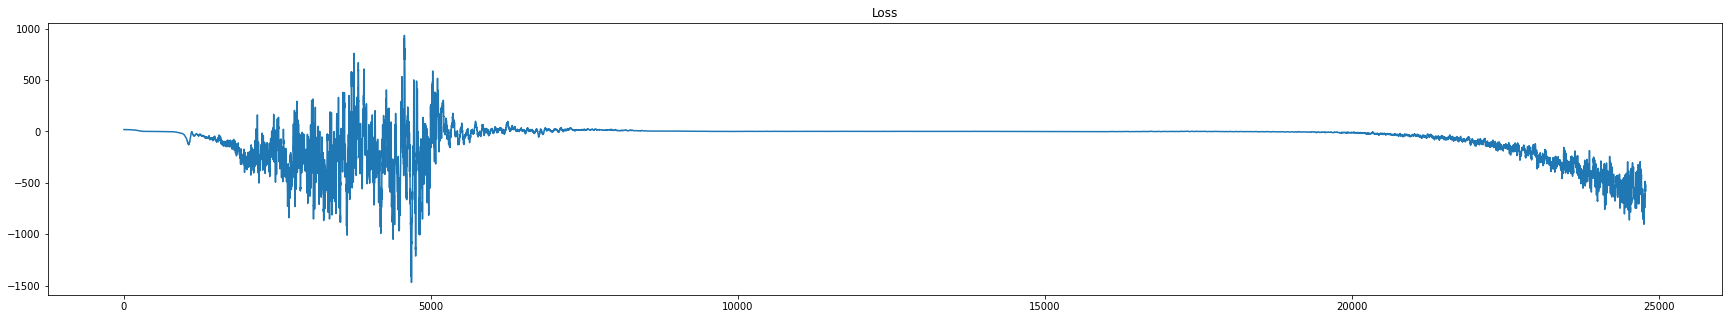

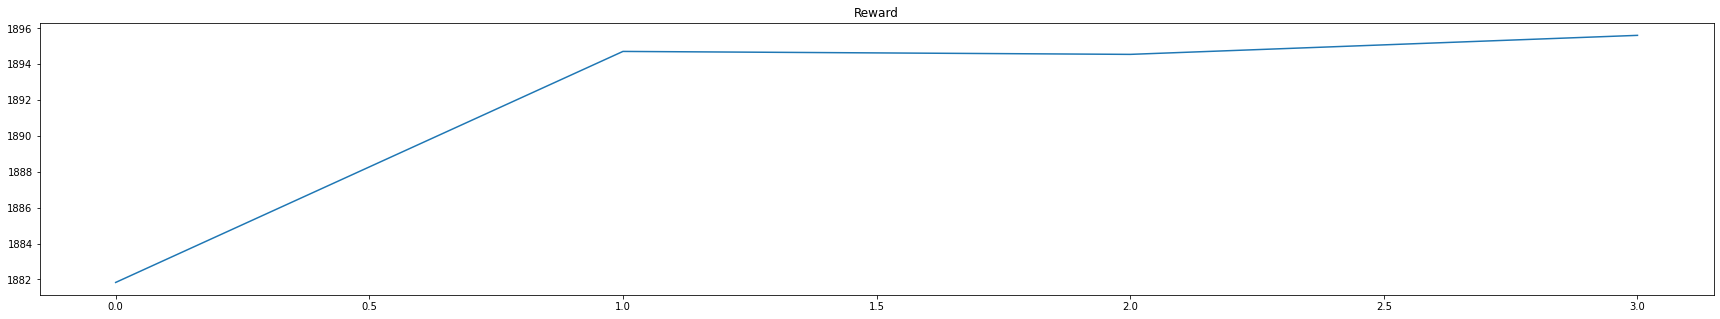

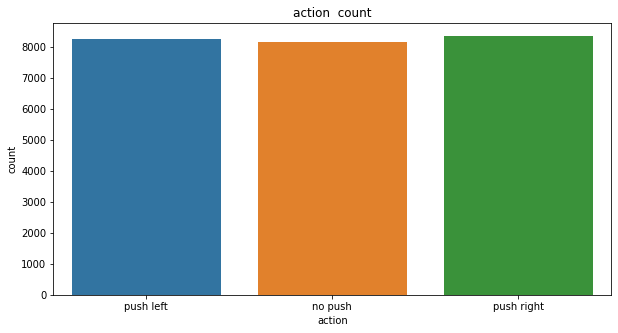

In [26]:
plt.figure(figsize=(30,5))
plt.plot(loss_df['loss_r30'])
plt.title('Loss')
plt.show()

plt.figure(figsize=(30,5))
plt.plot(reward_df['reward_r30'])
plt.title('Reward')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(action_df["action"], order=["push left", "no push","push right"])
plt.title("action  count")
plt.show()

In [13]:
# 10000エピソードで学習する
for episode in range(10):
    total_reward = 0
    observation = env.reset()
    for _ in range(1000):
        env.render()
        
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor([now_state])
        action =  agent.get_action(now_state)
        actions.append(action)
        
        next_observation, reward, done, _ = env.step(action)
        total_reward += reward
        observation = next_observation
        if observation[0]>=env.observation_space.high[0]-0.001:
            rewards.append(total_reward)
            # doneがTrueになったら１エピソード終了
            if episode%100 == 0:
                if episode==0:
                    mean_total_reward = total_reward
                else:
                    m = episode//100
                    mean_total_reward = np.mean(rewards[(m-1)*100:m*100])
                print(f'episode: {episode}, total_reward　mean: {mean_total_reward}')
            break

KeyboardInterrupt: 

In [27]:
x = agent.model(now_state)['policy']
print(x)
a = Categorical(logits=x)
print(a)

tensor([[-5679.2783, -3271.7991,  7068.2822]], grad_fn=<AddmmBackward>)
Categorical(logits: torch.Size([1, 3]))


In [28]:
torch.nn.LogSoftmax()(x)#(torch.nn.Softmax()(x))

tensor([[-12747.5605, -10340.0811,      0.0000]], grad_fn=<LogSoftmaxBackward>)

In [29]:
a.probs, a.logits

(tensor([[0., 0., 1.]], grad_fn=<SoftmaxBackward>),
 tensor([[-12747.5605, -10340.0811,      0.0000]], grad_fn=<SubBackward0>))

In [17]:
a.sample()

tensor([2])

In [30]:
now_state

tensor([[0.3157, 0.4894]])

In [63]:
low_0 = env.observation_space.low[0]
high_0 = env.observation_space.high[0]
low_1 = env.observation_space.low[1]
high_1 = env.observation_space.high[1]

df = []
for x_0 in np.arange(low_0, high_0,0.05):
    x=[]
    tmp_df = pd.DataFrame(index=np.arange(low_1, high_1,0.01))
    for x_1 in np.arange(low_1, high_1,0.01):
        x.append([x_0, x_1])

    x = torch.FloatTensor(x)
    y = agent.model(x)['value'].detach().numpy().flatten()
    tmp_df[x_0] = y
    df.append(tmp_df)

In [64]:
df = pd.concat(df, axis=1)

<AxesSubplot:>

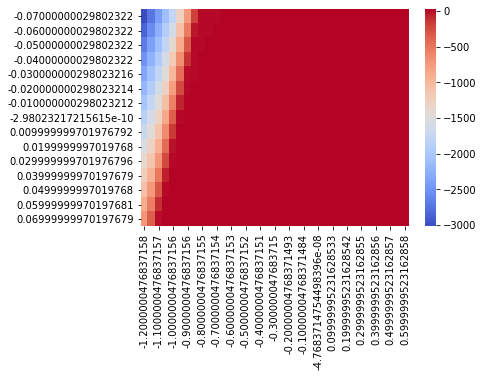

In [66]:
sns.heatmap(df, cmap='coolwarm')

In [67]:
df

,-1.2000000476837158,-1.1500000476837158,-1.1000000476837157,-1.0500000476837157,-1.0000000476837156,-0.9500000476837156,-0.9000000476837156,-0.8500000476837155,-0.8000000476837155,-0.7500000476837154,...,0.14999995231628538,0.19999995231628542,0.24999995231628547,0.2999999523162855,0.34999995231628556,0.3999999523162856,0.44999995231628565,0.4999999523162857,0.5499999523162857,0.5999999523162858
-7.000000e-02,-3016.178223,-2724.286865,-2415.875244,-2089.477783,-1763.079834,-1281.867676,-728.911194,-184.929916,16.948420,17.276033,...,23.173563,23.501078,23.828653,24.161844,24.496134,24.830484,25.165079,25.499735,25.833963,26.168558
-6.000000e-02,-2842.489502,-2554.260986,-2255.934326,-1929.537231,-1589.582153,-1072.606201,-519.649414,-20.213877,17.199984,17.527605,...,23.425028,23.752787,24.080240,24.411478,24.745829,25.080301,25.414652,25.749247,26.083536,26.418070
-5.000000e-02,-2672.462891,-2390.495117,-2095.993408,-1769.596558,-1389.651245,-863.344360,-310.387970,11.884947,17.451578,17.779161,...,23.676676,24.004251,24.331827,24.661295,24.995340,25.329813,25.664225,25.998819,26.333231,26.667704
-4.000000e-02,-2502.436768,-2231.072510,-1936.053345,-1609.656250,-1181.844971,-654.082275,-119.676018,17.375536,17.703165,18.030802,...,23.928202,24.255838,24.583536,24.911112,25.245035,25.579386,25.913980,26.248331,26.582804,26.917521
-3.000000e-02,-2342.733887,-2071.649658,-1776.112305,-1449.715454,-974.038086,-444.820404,2.692173,17.627131,17.954737,18.282389,...,24.179789,24.507364,24.834879,25.162577,25.494608,25.828897,26.163431,26.497660,26.832376,27.160746
-2.000000e-02,-2183.311768,-1912.227051,-1616.172119,-1258.350830,-766.231628,-239.714691,16.107103,17.878695,18.206354,18.533976,...,24.431314,24.758890,25.086771,25.414408,25.744181,26.078470,26.413004,26.747293,27.082071,27.395487
-1.000000e-02,-2023.889038,-1752.804565,-1456.231445,-1050.544434,-558.424866,-61.590229,17.802645,18.130297,18.457926,18.785547,...,24.683084,25.010477,25.338175,25.665873,25.993876,26.328287,26.662516,26.997110,27.316385,27.640238
-2.980232e-10,-1864.466553,-1593.382080,-1295.322754,-842.737915,-350.618256,8.986401,18.054262,18.381876,18.709497,19.037119,...,24.934488,25.262186,25.589701,25.917337,26.245035,26.577921,26.912088,27.241678,27.557230,27.885111
1.000000e-02,-1705.044067,-1433.959473,-1108.562012,-634.931396,-156.015396,17.978235,18.305849,18.633471,18.961100,19.288736,...,25.186075,25.513590,25.841349,26.169046,26.496683,26.827433,27.161783,27.475199,27.802408,28.129862
2.000000e-02,-1545.621460,-1274.537109,-919.243225,-427.124878,-6.419710,18.229784,18.557467,18.885080,19.212702,19.540308,...,25.437723,25.765421,26.092997,26.420511,26.748270,27.077372,27.397623,27.719400,28.047098,28.374857


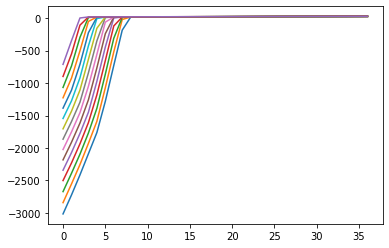

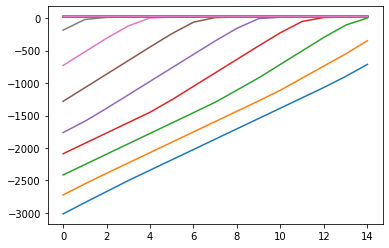

In [73]:
for i in range(len(df)):
    plt.plot(df.iloc[i,:].values)
plt.show()
for i in range(len(df.columns)):
    plt.plot(df.iloc[:,i].values)
plt.show()


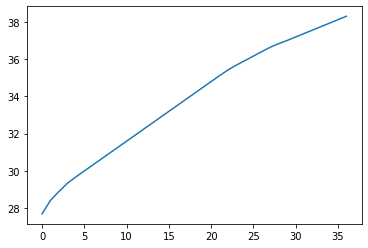

In [39]:
plt.plot(y['value'].detach().numpy())